# Analysis Notebook


## 1. Loading Data and Converting Data Types

In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
budgetsdf = pd.read_csv('Data/tn.movie_budgets.csv')

In [4]:
imdbconn = sqlite3.connect('Data/im.db')

In [5]:
df = budgetsdf.copy()

In [6]:
df['worldwide_gross'] = df['worldwide_gross'].apply(lambda x: x.replace('$', '').replace(',', ''))
df['domestic_gross'] = df['domestic_gross'].apply(lambda x: x.replace('$', '').replace(',', ''))
df['production_budget'] = df['production_budget'].apply(lambda x: x.replace('$', '').replace(',', ''))

In [7]:
df['worldwide_gross'] = df['worldwide_gross'].astype(float)
df['domestic_gross'] = df['domestic_gross'].astype(float)
df['production_budget'] = df['production_budget'].astype(float)

## 2. Calculating Gross to Budget Ratio, Assigning Categories, and Calculating Odds of Success

In [8]:
df['gtbratio'] = df['worldwide_gross']/df['production_budget']

In [9]:
# Source for Category Parameters = https://www.studiobinder.com/blog/production-budget/#:~:text=Film%20Budget%20Examples,-Low%2Dend%20movie&text=There's%20some%20conjecture%20as%20to,(2007)%20%E2%80%93%20Budget%3A%20%247%2C000

df['budgetcat'] = ['low' if x < 5000000 else 'mid' if x < 50000000 else 'high' for x in df['production_budget']]

In [10]:
df.shape

(5782, 8)

In [9]:
df['budgetcat'].value_counts()

mid     3192
low     1382
high    1208
Name: budgetcat, dtype: int64

In [10]:
# Assigning value counts to variables

mid = 3192
low = 1382
high = 1208

In [11]:
#Source1 for Profitability Parameters: https://gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305
#Source2 for Profitability Parameters: https://www.reddit.com/r/movies/comments/14e9irm/at_what_profit_margin_does_a_movie_become_worth_it/#:~:text=The%20rule%20of%20thumb%20often,order%20to%20turn%20a%20profit.

df['profitability'] = df['worldwide_gross']-(df['production_budget']*2)

In [12]:
df['success'] = ['no' if x < 0 else 'yes' for x in df['profitability']]

In [13]:
onlysuccessesdf = df.loc[df['success'] == 'yes']
onlysuccessesdf['budgetcat'].value_counts()

mid     1423
high     671
low      527
Name: budgetcat, dtype: int64

In [14]:
# Calculating Odds of Success

lowbudgetodds = 527/low
midbudgetodds = 1423/mid
highbudgetodds = 671/high

In [15]:
print(lowbudgetodds)
print(midbudgetodds)
print(highbudgetodds)

0.38133140376266283
0.4458020050125313
0.5554635761589404


## 3. Evaluating the Statistical Significance of the Relationship Between Budget Categories and Profitability Metrics

### 3a. Evaluating the Relationship Between Production Budget and Worldwide Gross

Is there a statistically significant relationship between production budget and worldwide gross?

H0: The null hypothesis is that there is no statistically significant relationship between production budget and worldwide gross.

H1: The alternative hypothesis is that there is a statistically significant relationship between production budget and worldwide gross.

We are willing to reject the null hypothesis if we achieve a certainty level of at least 95%.

In [16]:
stats.pearsonr(df['production_budget'], df['worldwide_gross'])

(0.7483059765694755, 0.0)

Because the P-value is below .05, we are willing to reject the null hypothesis with 95% confidence.

The Pearson correlation coefficient of .75 shows that there is a substantial positive correlation between production budget and worldwide gross.

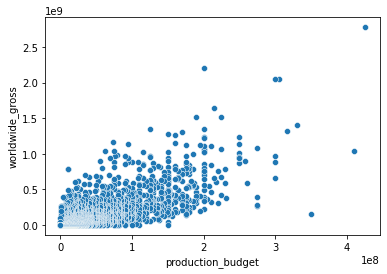

In [17]:
sns.scatterplot(x=df['production_budget'], y=df['worldwide_gross']);

### 3b. Evaluating the Relationship between Production Budget and Gross to Budget Ratio

Is there a statistically significant relationship between production budget and gross to budget ratio?

H0: The null hypothesis is that there is no statistically significant relationship between production budget and gross to budget ratio.

H1: The alternative hypothesis is that there is a statistically significant relationship between production budget and gross to budget ratio.

We are willing to reject the null hypothesis if we achieve a certainty level of at least 95%.

In [18]:
stats.pearsonr(df['production_budget'], df['gtbratio'])

(-0.04871481362951173, 0.0002108514213067043)

Because the P-value is below .05, we are willing to reject the null hypothesis with 95% confidence.

The Pearson correlation coefficient of -.04 shows that there is a almost no correlation between production budget and gross to budget ratio.

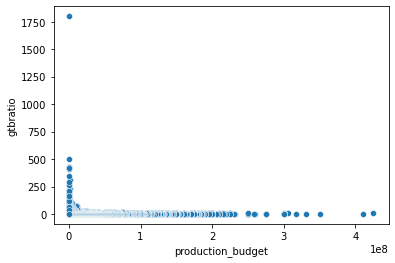

In [19]:
sns.scatterplot(x=df['production_budget'], y=df['gtbratio']);

The scatterplot shows us that while there is virtually no linear correlation between production budget and gross to budget ratio, the strongest outcomes for gross to budget ratio tend to come with movies with the lowest budgets.

### 3c. Evaluating the Relationship Between Budget Category and Achieving Success (Gross >= Two Times Budget)

Is there a statistically significant relationship between production budget and success?

H0: The null hypothesis is that there is no statistically significant relationship between production budget and success.

H1: The alternative hypothesis is that there is a statistically significant relationship between production budget and success.

We are willing to reject the null hypothesis if we achieve a certainty level of at least 95%.

In [20]:
contingency_table=pd.crosstab(index=df['budgetcat'],columns=df['success'])
stats.contingency.chi2_contingency(contingency_table)

(80.485492873084,
 3.332708168714908e-18,
 2,
 array([[ 660.40954687,  547.59045313],
        [ 755.53476306,  626.46523694],
        [1745.05569007, 1446.94430993]]))

Because the P-value is below .05, we are willing to reject the null hypothesis with 95% confidence.

### 3d. Evaluating the Relationship Between Budget Category and Gross to Budget Ratio

Is there a statistically significant relationship between budget category and gross to budget ratio?

H0: The null hypothesis is that there is no statistically significant relationship between budget category and gross to budget ratio.

H1: The alternative hypothesis is that there is a statistically significant relationship between budget category and gross to budget ratio.

We are willing to reject the null hypothesis if we achieve a certainty level of at least 95%.

In [21]:
model = ols('gtbratio ~ budgetcat', data = df).fit()

In [22]:
anova_table = sm.stats.anova_lm(model, typ=2)

In [23]:
print(anova_table)

                 sum_sq      df          F        PR(>F)
budgetcat  5.771150e+04     2.0  33.461644  3.558714e-15
Residual   4.983538e+06  5779.0        NaN           NaN


Because the P-value is below .05, we are willing to reject the null hypothesis with 95% confidence.

## 4. Determining Median and Mean Outcomes for Budget Categories

In [24]:
# Overall Median Outcome for Each Budget Category

df.groupby(by='budgetcat').median()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,50,80000000.0,78368442.5,184531488.0,2.227965,18902171.5
low,50,1500000.0,320090.5,840535.5,0.775750,-500000.0
mid,51,18000000.0,17979374.0,29876723.0,1.676872,-5109779.0


In [25]:
# Overall Mean Outcome for Each Budget Category

df.groupby(by='budgetcat').mean()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,50.195364,9.562994e+07,1.106004e+08,2.778329e+08,2.741431,8.657302e+07
low,49.965991,1.785378e+06,6.066987e+06,9.496835e+06,10.430517,5.926079e+06
mid,50.615288,2.025440e+07,3.136647e+07,5.646421e+07,3.141576,1.595540e+07


In [26]:
# Median Outcome for Each Budget Category Given Gross at Least Doubles Budget

onlysuccessesdf.groupby(by='budgetcat').median()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,52,85000000.0,130319208.0,328325007.0,3.415718,125500000.0
low,49,1700000.0,7282851.0,10941801.0,7.791578,6577401.0
mid,55,18000000.0,43853424.0,79114085.0,3.954347,33954968.0


In [27]:
# Mean Outcome for Each Budget Category Given Gross At Least Doubles Budget

onlysuccessesdf.groupby(by='budgetcat').mean()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,51.122206,1.045461e+08,1.631326e+08,4.231247e+08,4.070075,2.140324e+08
low,49.897533,1.866877e+06,1.519655e+07,2.375082e+07,26.800612,2.001707e+07
mid,52.872101,2.004222e+07,5.640001e+07,1.056163e+08,6.097461,6.553190e+07


In [28]:
# Median Outcome for Each Budget Category Given Gross Does Not Double Budget

onlyfailuresdf = df.loc[df['success'] == 'no']
onlyfailuresdf.groupby(by='budgetcat').median()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,47,70000000.0,38577772.0,78481410.0,1.094715,-65634502.0
low,50,1400000.0,15030.0,41914.0,0.046394,-1999297.0
mid,47,18000000.0,6800000.0,11367029.0,0.669099,-19189806.0


In [29]:
# Mean Outcome for Each Budget Category Given Gross Does Not Double Budget

onlyfailuresdf = df.loc[df['success'] == 'no']
onlyfailuresdf.groupby(by='budgetcat').mean()

,id,production_budget,domestic_gross,worldwide_gross,gtbratio,profitability
budgetcat,,,,,,
high,49.037244,8.448883e+07,4.495952e+07,9.628573e+07,1.081244,-7.269193e+07
low,50.008187,1.735144e+06,4.397615e+05,7.110437e+05,0.340412,-2.759244e+06
mid,48.799887,2.042508e+07,1.122925e+07,1.692577e+07,0.763834,-2.392440e+07


## 5. Analyzing the Relationship Between Genre and Profitability in Low Budget Films

In [30]:
lowdf = df.loc[df['budgetcat'] == 'low']

In [31]:
genres1 = pd.read_sql("""
SELECT primary_title, genres
FROM movie_basics
;
""", imdbconn)

In [32]:
genres1df = lowdf.merge(genres1, left_on='movie', right_on='primary_title', how='inner')

In [33]:
genres1clean = genres1df.dropna(subset=['genres'])

In [34]:
duplicates = genres1df[genres1df.duplicated(subset=['id'],keep=False)]
duplicates

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gtbratio,budgetcat,profitability,success,primary_title,genres
0,1,23-Jan-15,Mommy,4900000.0,3498695.0,17536004.0,3.578776,low,7736004.0,yes,Mommy,Drama
1,1,23-Jan-15,Mommy,4900000.0,3498695.0,17536004.0,3.578776,low,7736004.0,yes,Mommy,Drama
2,4,17-Aug-12,The Awakening,4900000.0,95933.0,6924321.0,1.413127,low,-2875679.0,no,The Awakening,"Horror,Thriller"
3,4,17-Aug-12,The Awakening,4900000.0,95933.0,6924321.0,1.413127,low,-2875679.0,no,The Awakening,"Horror,Thriller"
4,4,17-Aug-12,The Awakening,4900000.0,95933.0,6924321.0,1.413127,low,-2875679.0,no,The Awakening,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...
969,68,6-Jul-01,Cure,10000.0,94596.0,94596.0,9.459600,low,74596.0,yes,Cure,None
970,70,1-Apr-96,Bang,10000.0,527.0,527.0,0.052700,low,-19473.0,no,Bang,None
971,73,13-Jan-12,Newlyweds,9000.0,4584.0,4584.0,0.509333,low,-13416.0,no,Newlyweds,"Comedy,Drama"
972,78,31-Dec-18,Red 11,7000.0,0.0,0.0,0.000000,low,-14000.0,no,Red 11,"Horror,Sci-Fi,Thriller"


In [35]:
genres1cleannodups = genres1clean.drop_duplicates(subset=['id'])

In [36]:
valcnts = genres1cleannodups['genres'].value_counts()

In [37]:
valcnts

Drama                              10
Drama,Romance                       7
Documentary                         7
Comedy,Drama                        5
Horror                              5
Horror,Thriller                     4
Crime,Drama                         3
Comedy,Drama,Romance                3
Drama,Mystery,Sci-Fi                3
Comedy                              3
Drama,Thriller                      3
Drama,Horror,Mystery                2
Crime,Drama,Horror                  2
Comedy,Horror                       2
Horror,Sci-Fi,Thriller              2
Drama,Horror,Thriller               2
Action,Crime,Drama                  2
Comedy,Romance                      2
Action,Crime,Horror                 1
Action,Comedy,Crime                 1
Action,Adventure,Western            1
Drama,Horror                        1
Drama,Mystery,Romance               1
Action,Horror                       1
Comedy,Drama,Sport                  1
Thriller                            1
Action,Myste

Once we clean the data after merging the budget database with the IMDB database, we have insufficient data to analyze the relationship between genre and profitability in low-budget films.